# Regression forecast with seasonality

## 1. Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Changing parameters
pd.set_option('float_format', '{:_.2f}'.format)

## 2. Loading the data

In [3]:
sales = pd.read_parquet('DATA/sales.parquet')

# Inserting new columns to get the month and the year
sales['DATE'] = pd.to_datetime(sales['DATE'], format='%d/%m/%y')
sales['YEAR'] = sales['DATE'].dt.year
sales['MONTH'] = sales['DATE'].dt.month
sales['STORE ID'] = sales['STORE ID'].astype('category')
sales['CUSTOMER ID'] = sales['CUSTOMER ID'].astype('category')
sales['PRODUCT'] = sales['PRODUCT'].astype('category')

## 3. Cleaning and transforming the data

In [4]:
# Droping non-used rows
sales = sales[~sales['STORE ID'].isin(['STORE_5'])]

# Filtering the data
store = 'STORE_2'

# Pivoting the table by the store to get the revenue per store per month
store_id = sales[sales['STORE ID'] == store]
store_id = store_id.reset_index().copy()
store_id = store_id.drop(columns='index')
pvt = store_id.pivot_table('TOTAL AMOUNT', index=['YEAR', 'MONTH'], aggfunc='sum')
pvt = pvt.reset_index()
pvt = pvt.reset_index()

In [5]:
# Inserting the last 3 month reforcast
pvt['index'] = pvt['index'] + 1
pvt['X'] = pvt['index']
pvt['Y'] = pvt['TOTAL AMOUNT']
pvt = pvt.drop(columns=['index', 'YEAR', 'MONTH', 'TOTAL AMOUNT'])
pvt = pvt.drop(axis=0, index=45)

STORE_1 = pd.DataFrame({'X': [46, 47, 48], 'Y':[3812768.6, 3956368.1, 3964486.0]})
STORE_2 = pd.DataFrame({'X': [46, 47, 48], 'Y':[918437.5, 874062.5, 835312.5]})
STORE_3 = pd.DataFrame({'X': [46, 47, 48], 'Y':[453125.0, 453125.0, 437500.0]})
STORE_4 = pd.DataFrame({'X': [46, 47, 48], 'Y':[656250.0, 656250.0, 625000.0]})

if store_id.loc[0, 'STORE ID'] == 'STORE_1':
    pvt = pd.concat([pvt, STORE_1], ignore_index=True)
elif store_id.loc[0, 'STORE ID'] == 'STORE_2':
    pvt = pd.concat([pvt, STORE_2], ignore_index=True)
elif store_id.loc[0, 'STORE ID'] == 'STORE_3':
    pvt = pd.concat([pvt, STORE_3], ignore_index=True)
elif store_id.loc[0, 'STORE ID'] == 'STORE_4':
    pvt = pd.concat([pvt, STORE_4], ignore_index=True)

## 4. Forecast

In [6]:
# Determining the linar regression function using least square method
pvt['Xmean'] = pvt['X'].mean()
pvt['Ymean'] = pvt['Y'].mean()
pvt['xi - Xmean'] = pvt['X'] - pvt['Xmean']
pvt['yi - Ymean'] = pvt['Y'] - pvt['Ymean']

a = (pvt['xi - Xmean'] * pvt['yi - Ymean']).sum() / (pvt['xi - Xmean']**2).sum()
b = pvt['Y'].mean() - (a * pvt['X'].mean())
pvt['Yp'] = a * pvt['X'] + b

print(f'y = {a}x + {b}')

# Determining the linar regression function using least square with sklearn
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(pvt[['X']], pvt['Y'])
reg.score(pvt[['X']], pvt['Y'])

print(f'y = {reg.coef_}x + {reg.intercept_}')

y = 4351.655718735244x + 626947.7721397496
y = [4351.65571874]x + 626947.7721397496


In [7]:
# Finding the seasonality
pvt['Y/Yp'] = pvt['Y'] / pvt['Yp']
coef = pd.DataFrame({'X1': [i for i in range(1, 13)], 'Y/Yp1': pvt['Y/Yp'].iloc[0:12].to_list(),
                     'X2': [i for i in range(13, 25)], 'Y/Yp2': pvt['Y/Yp'].iloc[12:24].to_list(),
                     'X3': [i for i in range(25, 37)], 'Y/Yp3': pvt['Y/Yp'].iloc[24:36].to_list(),
                     'X4': [i for i in range(37, 49)], 'Y/Yp4': pvt['Y/Yp'].iloc[36:48].to_list()})
coef['Y/Yp'] = (coef['Y/Yp1'] + coef['Y/Yp2'] + coef['Y/Yp3'] + coef['Y/Yp4']) / 4
coef = coef[['X1', 'Y/Yp']]
coef

,X1,Y/Yp
0,1,0.90
1,2,0.89
2,3,0.96
3,4,0.89
4,5,0.90
5,6,0.99
6,7,1.11
7,8,1.01
8,9,1.01
9,10,1.12


In [8]:
# Forecast
proj = pd.DataFrame({'X': [i for i in range(49, 61)]})
proj["Y'"] = a * proj['X'] + b
proj['coef'] = coef['Y/Yp']
proj['Yrect'] = proj["Y'"] * proj['coef']
proj['Y'] = proj['Yrect'] 
proj = proj[['X', 'Y']]
pvt = pvt[['X', 'Y']]
pvt = pd.concat([pvt, proj], ignore_index=True)
pvt['Y'] = pvt['Y']

periode =[]
for year in range(21, 26):
    for month in ['jan', 'fev', 'mar', 'avr', 'may', 'june', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec']:
        periode.append(f'{month}-{year}')
periode = pd.DataFrame({'per': periode})

pvt['X'] = periode['per']
pvt['Periode'] = pvt['X']
pvt['revenue'] = pvt['Y']
pvt = pvt[['Periode', 'revenue']]

forecast = pd.DataFrame({'month': ['jan', 'fev', 'mar', 'avr', 'may', 'june', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec'],
                       'revenue': pvt.loc[48:59, 'revenue'].to_list()})
forecast

,month,revenue
0,jan,759_048.75
1,fev,754_923.02
2,mar,811_045.58
3,avr,755_409.54
4,may,767_786.87
5,june,849_432.36
6,jul,963_790.79
7,aug,879_181.52
8,sept,883_894.00
9,oct,981_887.16


In [9]:
# Determing the growth vs N-1
evo = (pvt.loc[48:59, 'revenue'].sum() - pvt.loc[36:47, 'revenue'].sum()) / pvt.loc[36:47, 'revenue'].sum()
print(f'{evo:.2%}')

10.47%


In [10]:
# Moving average (5 months)
ma = []

for i in pvt.index:
    if i ==0:
        mean_ = pvt.loc[i, 'revenue']
        ma.append(mean_)
    elif i == 1:
        mean_ = (pvt.loc[i, 'revenue'] + pvt.loc[i-1, 'revenue']) / 2
        ma.append(mean_)
    elif i == 2:
        mean_ = (pvt.loc[i, 'revenue'] + pvt.loc[i-1, 'revenue'] + pvt.loc[i-2, 'revenue']) / 3
        ma.append(mean_)
    elif i == 3:
        mean_ = (pvt.loc[i, 'revenue'] + pvt.loc[i-1, 'revenue'] + pvt.loc[i-2, 'revenue'] + pvt.loc[i-3, 'revenue']) / 4
        ma.append(mean_)
    else:
        mean_ = (pvt.loc[i, 'revenue'] + pvt.loc[i-1, 'revenue'] + pvt.loc[i-2, 'revenue'] + pvt.loc[i-3, 'revenue'] + pvt.loc[i-4, 'revenue']) / 5
        ma.append(mean_)

pvt['ma5'] = pd.DataFrame({'ma5':ma})
pvt = pvt.set_index('Periode')

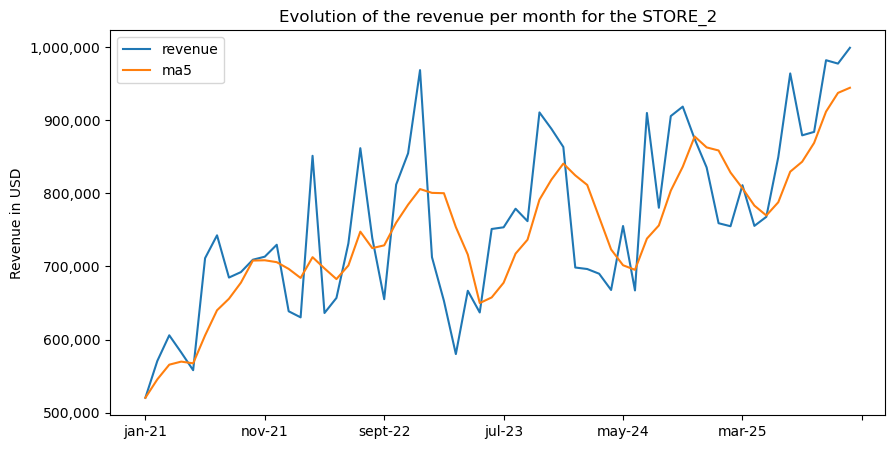

In [11]:
# Plotting the result
ax= pvt.plot(kind='line', figsize=(10,5))
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))
plt.xlabel('')
plt.ylabel('Revenue in USD')
plt.title(f'Evolution of the revenue per month for the {store}')
plt.show()